In [36]:
import numpy as np
import pandas as pd
from scipy import stats

In [48]:
n = 800
mean = [0, 0]
cov = [[1, 0.75], [0.75, 1]] # корреляция = 0.75

In [50]:
df = np.random.multivariate_normal(mean, cov, size=n)
uniform_df = stats.norm.cdf(df)

column1 = stats.norm.ppf(uniform_df[:, 0], loc=0, scale=1)
column2 = stats.expon.ppf(uniform_df[:, 1], scale=1)  # scale = 1/λ

df = pd.DataFrame({"x2": column1, "x3": column2})

In [52]:
df['x2'].corr(df['x3'])

0.6769871591813026

**Я сгенерировал x2 и x3 из разных распределений (нормальное и экспоненциальное), при этом заранее задал желаемую корреляцию, использовав преобразование в равномерное распределение). Из-за специфики распределений корреляция чуть меньше желаемой, но все равно высокая**

In [66]:
df['x3'].mean()

0.9816365230850157

In [68]:
df['x2'].mean()

0.0051410560153886346

In [78]:
# латентная переменная
# пусть b1 = -0.4, b2 = 0.77, b3 = -0.01, eps - ошибка, пусть она имеет логистическое распределение (0, 1)
eps = np.random.logistic(0, 1, n)  # Логистический шум
df['y_lat'] = -0.4 + 0.77*df['x2'] - 0.01*df['x3'] + eps

In [80]:
df

,x2,x3,y_lat,y_bin
0,0.551034,0.675314,1.782376,1
1,-0.264453,0.268328,0.340538,0
2,0.455592,0.990988,-0.025076,0
3,0.853508,0.743261,1.011323,1
4,0.680034,1.123660,0.486977,1
...,...,...,...,...
795,0.516978,1.500120,1.300517,0
796,-0.699562,0.124314,-0.018655,0
797,-0.379718,0.655181,5.167327,0
798,0.169328,0.713488,0.062040,0


In [82]:
#бинарная переменная
df['y_bin'] = df['y_lat'].apply(lambda x: 1 if x>0 else 0)

In [84]:
df['y_bin'].value_counts()

y_bin
0    490
1    310
Name: count, dtype: int64

# b)

**Хотим оптимизировать такую функцию**

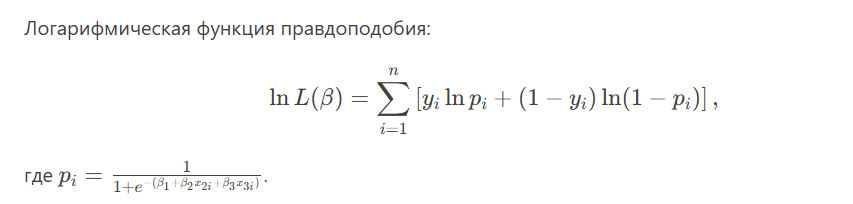

In [462]:
from scipy.optimize import minimize
def ln_likelihood(b, X, y): #b - матрица коэффициентов
    y_hat = b[0] + b[1]*X.iloc[: ,0] + b[2]*X.iloc[: ,1]
    p = 1/(1+np.exp(-y_hat))
    ln_l = np.sum(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10)) # я прочитал, что для лучшей сходимости и исключения случаев ln(0) принято добавлять 1e-10(мал число)
    func = -ln_l #в scipy optimize реализована минимизация, поэтому используем -ln(L), это эквивалентно максимизации ln(L)
    return func

In [464]:
X = df[['x2', 'x3']]
y = df['y_bin']

In [466]:
start_b = [0, 0, 0] # задаю стартовые b для оптимизации, принято начинать с 0 (константное предсказание)
result = minimize(ln_likelihood, start_b, args=(X, y), method='BFGS')
b_opt = result.x
#return b_opt

In [107]:
b_opt

array([-0.46376484,  0.7578168 , -0.05200798])

In [488]:
# считаю оценки готовой функцией

import statsmodels.api as sm
X_sm = X.copy()
X_sm = sm.add_constant(X_sm)
y_sm = y.copy()

logit = sm.Logit(y_sm, X_sm)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.616332
         Iterations 5


In [490]:
result.params

const   -0.463765
x2       0.757817
x3      -0.052008
dtype: float64

In [492]:
result

**Результаты идентичны**

In [116]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  y_bin   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Sun, 27 Apr 2025   Pseudo R-squ.:                 0.07682
Time:                        19:23:54   Log-Likelihood:                -493.07
converged:                       True   LL-Null:                       -534.09
Covariance Type:            nonrobust   LLR p-value:                 1.520e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4638      0.125     -3.711      0.000      -0.709      -0.219
x2             0.7578      0.114      6.643      0.000       0.534       0.981
x3            -0.0520      0.104     -0.501      0.6

# c)

Предельный эффект для класса 1 вычисляем следующим образом:

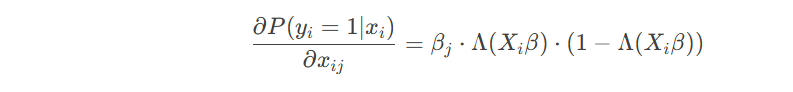

Здесь мы пользуемся свойством логистического распределения, что f = F(1-F), где f - функция плотности, F - функция распределения

Предельный эффект для класса 0 можем рассчитать как отрицательный предельный эффект для класса 1, так как при изменении вероятности попадания в 1 класс вероятность попадания в другой изменяется в противоположную сторону эквивалентно

In [149]:
def marginal_effects(X, b):

    X = np.asarray(X)
    b = np.asarray(b)
    
    Xb = X @ b
    
    p1 = 1 / (1 + np.exp(-Xb))
    
    margeffect_1 = b.reshape(1, -1) * (p1 * (1 - p1)).reshape(-1, 1)
    
    margeffect_0 = -margeffect_1
    
    return margeffect_1, margeffect_0

In [155]:
margeffect_1, margeffect_0 = marginal_effects(X_sm, result.params)

In [161]:
# средние предельные эффекты для const, x2, x3

In [157]:
print(np.mean(margeffect_1, axis=0))

[-0.09921709  0.16212606 -0.01112649]


In [159]:
print(np.mean(margeffect_0, axis=0))

[ 0.09921709 -0.16212606  0.01112649]


**Полная функция для расчета предельных эффектов, их стандартных ошибок, z-статистик и p-value для проверки значимости коэфов**:

In [449]:
def marginal_effects_etc(X, model_results):

    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    b = np.asarray(model_results.params)
    if b.ndim > 1:
        b = b.flatten()

    Xb = X @ b
    
    p = 1 / (1 + np.exp(-Xb))
    
    ame = np.mean((p * (1 - p)).reshape(-1, 1) * X, axis=0) #считаю средний предельный эффект
    
    cov_b = model_results.cov_params()
    if cov_b.ndim != 2:
        cov_b = cov_b.reshape(len(b), len(b))
    
    P = p * (1 - p)
    dP = p * (1 - p) * (1 - 2*p) #дельта метод
    grad = np.zeros((len(b), len(b))) #делаю матрицу 3 на 3
    for j in range(len(b)):
        grad[j] = np.mean(P[:, np.newaxis] * X[:, j][:, np.newaxis] * X + dP[:, np.newaxis] * Xb[:, np.newaxis] * X[:, j][:, np.newaxis] * X, axis=0)    
    cov_ame = grad.dot(cov_b).dot(grad.T) # ков матрица предельных эффектов
    
    std_errors = np.sqrt(np.diag(cov_ame))
    
    z_stats = ame / std_errors
    
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_stats)))
    
    return {
        'marginal_effects': ame,
        'std_errors': std_errors,
        'z_stats': z_stats,
        'p_values': p_values
    }

In [451]:
result.params

const   -0.463765
x2       0.757817
x3      -0.052008
dtype: float64

In [453]:
effects = marginal_effects_etc(X_sm, result)

In [455]:
effects

{'marginal_effects': array([0.21393834, 0.02969943, 0.22382702]),
 'std_errors': array([0.01270277, 0.00826443, 0.01976031]),
 'z_stats': array([16.84186446,  3.59364397, 11.32710168]),
 'p_values': array([0.        , 0.00032609, 0.        ])}

## Красивый вывод с помощью таблицы

Я не знал как делать такие таблички, поэтому сгенерировал с помощью нейросети

In [459]:
from tabulate import tabulate


variables = ['const', 'x2', 'x3']

table_data = []
for i, var in enumerate(variables):
    row = [
        var,
        f"{effects['marginal_effects'][i]:.6f}",
        f"{effects['std_errors'][i]:.6f}",
        f"{effects['z_stats'][i]:.6f}",
        f"{effects['p_values'][i]:.6f}"
    ]
    table_data.append(row)

headers = [
    "Variable", 
    "Coef.", 
    "Std.Err.", 
    "z-stat", 
    "P>|z|"
]

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".6f"))

+------------+----------+------------+-----------+----------+
| Variable   |    Coef. |   Std.Err. |    z-stat |    P>|z| |
+============+==========+============+===========+==========+
| const      | 0.213938 |   0.012703 | 16.841864 | 0.000000 |
+------------+----------+------------+-----------+----------+
| x2         | 0.029699 |   0.008264 |  3.593644 | 0.000326 |
+------------+----------+------------+-----------+----------+
| x3         | 0.223827 |   0.019760 | 11.327102 | 0.000000 |
+------------+----------+------------+-----------+----------+


# d)

Далее в тестах понадобится логарифм правдоподобия, поэтому я написал отдельную функцию для его вычисления

In [205]:
def logit_loglikelihood(b, X, y): #аргументы: b - оценки коэффициентов модели(вектор), X - матрица объекты-признаки, y - вектор объясняемой переменной (бинарная)  
    Xb = X @ b
    loglike = np.sum(y * Xb - np.log(1 + np.exp(Xb))) # вычисляю логарифм правдоподобия(ниже описал формулу)
    return loglike

loglike считаю именно так для удобства, нашел вот такое преобразование:

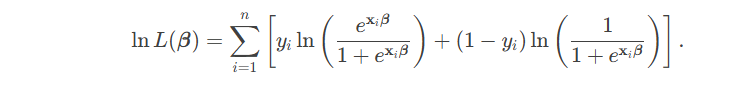

Это привычный вид. Если расписать выражения под логарифмами как разность логарифмов, получится:

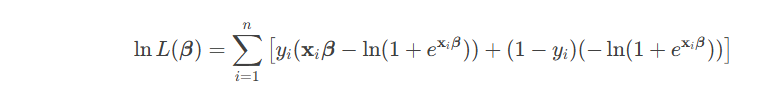

Раскрываем скобки, получаем:

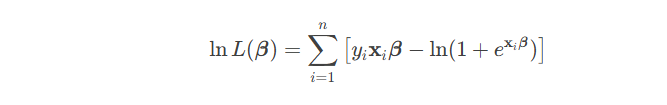

Что я и считаю в функции

## LR тест

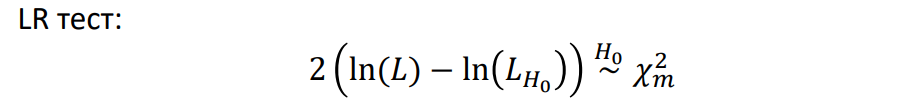

Если ограничения верны, то значения функций правдоподобия у полной и restricted модели близки, следовательно, статистика близка к 0.\
Статистика будет всегда положительной, так как значение правдоподобия restricted модели не может быть больше значения правдоподобия полной.\
Сравниваем с хи-квадратом, так как при больших выборках разность логарифмов правдоподобий похожа на сумму квадратов нормальных величин (про это раньше не знал, прочитал)

In [284]:
def lr_test(b_full, b_restr, X, X_restr, y):#аргументы: #аргументы: b_full - оценки коэффициентов исходной модели(вектор), 
    #b_restr - оценки коэффициентов  модели с ограничениями(вектор), 
    #X - матрица объекты-признаки, y - вектор объясняемой переменной (бинарная)
    ll_full = logit_loglikelihood(b_full, X, y)
    ll_restr = logit_loglikelihood(b_restr, X_restr, y)
    
    LR_stat = 2 * (ll_full - ll_restr)
    m = len(b_full) - len(b_restr) #количество ограничений (оно как раз равно разнице между количеством коэфов в двух моделях)
    p_value = 1 - chi2.cdf(LR_stat, m) # считаем p_value как 1 - ф.р 
    
    return {'LR_stat': LR_stat, 'p_value': p_value, 'Количество ограничений': m}

## Тест Вальда

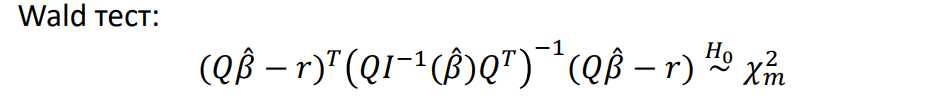

Далее будет нужна ковариационная матрица оценок, вот отдельная функция для ее вычисления:

In [298]:
def cov_apr(b, X):
    Xb = X @ b
    p = 1 / (1 + np.exp(-Xb))
    W = np.diag(p * (1 - p))
    cov = np.linalg.inv(X.T @ W @ X)
    return cov

In [294]:
def wald_test(b, cov, Q, r): # аргументы: b - оценки коэффициентов модели(вектор), Q - матрица ограничений, r - вектор ограничений
    # cov - ковариационная матрица оценок

    Qb_minus_r = Q @ b - r
    cov_Q = Q @ cov @ Q.T
    W_stat = Qb_minus_r.T @ np.linalg.inv(cov_Q) @ Qb_minus_r
    
    m = Q.shape[0] #количество ограничений
    p_value = 1 - chi2.cdf(W_stat, m)
    
    return {'W_stat': W_stat, 'p_value': p_value, 'Количество ограничений': m}

## Тест множителей Лагранжа

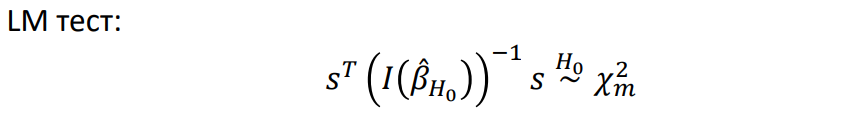

**s** - это вектор градиент логарифма функции правдоподобия.

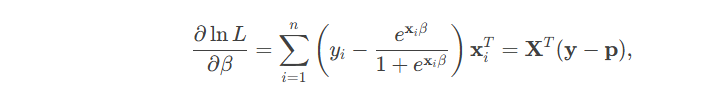

(тут конкретно для логит модели)

Идея теста - проверить, насколько верны ограничения. Если они верны, то оцененная вероятность (p) близка к реальному значению (y), следовательно градиент близок к 0

**I** - информационная матрица Фишера

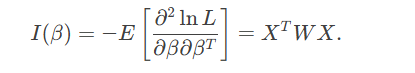

где **W** - это диагональная матрица весов. По диагонали у нее стоят дисперсии. В бинарной логит модели Var(y) = p(1-p) (как в распределении Бернулли)

In [304]:
def lm_test(b_restr, X, y):
    Xb = X @ b_restr
    p = 1 / (1 + np.exp(-Xb)) # оценка вероятности
    s = X.T @ (y - p) # градиент логарифма правдоподобия
    
    W = np.diag(p * (1 - p)) # диагональная матрица весов 
    I = X.T @ W @ X
    
    LM_stat = s.T @ np.linalg.inv(I) @ s
    m = X.shape[1] - len(beta_restricted) # количество ограничений (равно разности количества коэффициентов в полной и restricted модели) (эта версия подходит,
    # если проверяем гипотезу о равенстве коэффициентов 0)
    p_value = 1 - chi2.cdf(LM_stat, m) # тестовая статистика - хи-квадрат с m степенями свободы
    
    return {'LM_stat': LM_stat, 'p_value': p_value, 'Количество ограничений': m}

# e)

**Проверим гипотезу**\
**H0**: b3 = 0\
**H1**: b3 != 0

## LR тест

Найдем оценки коэффициентов restricted модели:

In [482]:
X_restr = df[['x2']]

In [484]:
X_restr_sm = sm.add_constant(X_restr)
logit_restr = sm.Logit(y_sm, X_restr_sm)
result_restr = logit_restr.fit()

Optimization terminated successfully.
         Current function value: 0.616489
         Iterations 5


In [486]:
result_restr

In [262]:
b_restr = np.array(result_restr.params)

In [264]:
b_full = b_opt

In [280]:
from scipy.stats import chi2

In [286]:
lr_e = lr_test(b_full, b_restr, X_sm, X_restr_sm, y_sm)

In [288]:
lr_e

{'LR_stat': 0.2505545425102582,
 'p_value': 0.6166848774525525,
 'Количество ограничений': 1}

p_value > 0.05 => **H0 не отвергается, следовательно, переменная x3 не значима в данной модели**

### Сравнение с готовой функцией

## тест Вальда

**Проверим гипотезу**\
**H0**: b2 = 1\
**H1**: b2 != 1

In [300]:
cov = cov_apr(b_full, X_sm)
Q = np.array([[0, 1, 0]])  #тестирую b2 = 1
r = np.array([1])
wald = wald_test(b_full, cov, Q, r)
print("Wald Test:", wald)

Wald Test: {'W_stat': 4.5070577745060705, 'p_value': 0.033755257563173435, 'Количество ограничений': 1}


p_value < 0.05 => **гипотеза о равенстве коэффициента при x2 единице отвергается на 5% уровне значимости**

### Сравнение с готовой функцией

In [494]:
result

In [498]:
h0 = 'x2 = 1'
wald_test = result.wald_test(h0)


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [502]:
print("W_stat", wald_test.statistic)
print("p_value =", wald_test.pvalue)

W_stat [[4.50705864]]
p_value = 0.033755240448910304


**результаты совпадают!**

## LM тест

**Проверим гипотезу**\
**H0**: b2= 1\
**H1**: b2 != 1

Так как я решил проверять гипотезу о равенстве коэффициента числу != 0, указываю m=1

In [ ]:
Также у меня в гипотезе только 1 коэф, поэтому статистику считаем только для b3

In [342]:
def lm_test_e(b_restr, X, y):
    Xb = X @ b_restr
    p = 1 / (1 + np.exp(-Xb)) # оценка вероятности
    s = X.T @ (y - p) # градиент логарифма правдоподобия

    s_b3 = s[2]
    
    W = np.diag(p * (1 - p)) # диагональная матрица весов 
    I = X.T @ W @ X
    I_inv = np.linalg.inv(I)
    I_b3 = I_inv[2, 2]
    
    LM_stat = (s_b3**2) * I_b3
    m = 1
    p_value = 1 - chi2.cdf(LM_stat, m) # тестовая статистика - хи-квадрат с m степенями свободы
    
    return {'LM_stat': LM_stat, 'p_value': p_value, 'Количество ограничений': m}

Чтобы обучить restricted модель, я использую ранее написанный подход, только изначально задаю b3=1

In [345]:
def ln_likelihood_e(b, X, y):
    y_hat = b[0] + b[1]*X['x2'] + 1*X['x3']
    p = 1/(1 + np.exp(-y_hat))
    ln_l = np.sum(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
    return -ln_l
    
start_b = [0, 0] #оцениваем только b1 и b2, поэтому на этот раз 2 значения 

result = minimize(ln_likelihood_e, start_b, args=(X, y), method='BFGS')
b_opt = result.x 
b_restr = np.array([b_opt[0], b_opt[1], 1.0])

In [347]:
lm = lm_test_e(b_restr, X_sm, y_sm)

C:\Users\User\AppData\Local\Temp\ipykernel_15708\1654794204.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_b3 = s[2]


In [349]:
lm

{'LM_stat': 114.7642560073577, 'p_value': 0.0, 'Количество ограничений': 1}

p_value < 0.05 => **гипотеза о равенстве коэффициента при x2 единице отвергается на 5% уровне значимости**

# f)

Проверим гипотезу:\
**H0:** b2 + b3 = 0.7\
**H1:** b2 + b3 != 0.7

## LR тест

In [370]:
def ln_likelihood_f(b, X, y):
    b2 = 0.5 - b[1]
    y_hat = b[0] + b[1]*X['x2'] + b2*X['x3']
    p = 1/(1 + np.exp(-y_hat))
    ln_l = np.sum(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
    return -ln_l
    
start_b = [0, 0]
result = minimize(ln_likelihood_f, start_b, args=(X_sm, y_sm), method='BFGS')
b_opt = result.x 
b_restr = np.array([b_opt[0], b_opt[1], 0.5 - b_opt[1]])

In [372]:
b_restr

array([-0.36628654,  0.62982995, -0.12982995])

In [374]:
lr_f = lr_test(b_full, b_restr, X_sm, X_sm, y_sm)

In [376]:
lr_f

{'LR_stat': 5.363601353623494, 'p_value': nan, 'Количество ограничений': 0}